In [576]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [577]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

In [578]:
rng = np.random.default_rng()


signal_rate = 0.50206743e-3 # hits/sec (delta fxn)
fourweeks = 3600*24*28 # 4 weeks in seconds
Nsignal = int(signal_rate*fourweeks)

E_tot = 8.4736 # MeV
M = (29*931.5 - 21.895) # mass of Si29 (MeV)
E1 = -M + np.sqrt(M**2 + 2*M*E_tot)
E1_lm = E1**2/2/M

# highmass resolution
dE = 0.8#E1/5 # MeV (energy bin width)
#hm_bg_drate = 0.004625 # hits/sec/MeV
hm_bg_rate = 10*0.00555 #hm_bg_drate*dE # hits/sec in bin

# lowmass resolution
dE_lm = 500e-6#E1_lm/5 # MeV (energy bin width)
#lm_bg_drate = 70.3 # hits/sec/MeV
lm_bg_rate = 10*0.00555 #lm_bg_drate*dE_lm # hits/sec

In [763]:
def thermal_broadening():
    S = 8.4736
    M = (29*931.5 - 21.895)
    z = -1 # aligned with gamma (+1) or antialigned (-1)
    p0 = g0 = -M + np.sqrt(M**2 + 2*M*S) # gamma energy (zero temp)
    K0 = p0**2/2/M # NR energy (zero temp)
    #T = (1e0)*1/40/1e6 # temperature ~1/40 eV
    T = 8.617333262145e-11*(20e-3) # MeV/K x 20mK
    p1 = -M + np.sqrt(M**2 + 2*M*S + M*T - 2*z*np.sqrt(T*M**3)) # nuclear momentum
    K1 = p1**2/2/M # NR energy
    g1 = p1 + z*np.sqrt(M*T) # gamma energy
    dg = p0 - g1 # shift in gamma energy
    dg1 = p0*np.sqrt(T/M) # order of shift?

    Ei = S + T/2
    Ef = p1**2/2/M + p1 + z*np.sqrt(M*T)
    dNR = (K1 - T/2 - K0)


    #print('p0', p0)
    #print('p1', p1)
    #print('T', T)
    print('T/M', T/M)
    print('T/S', T/S)
    print('dp/p0', (p1 - p0)/p0)
    print('dK/K0', (K1-K0)/K0)
    print('dNR/NR', (K1-T/2-K0)/K0)
    print('dg/g0', dg/g0)
    print('dg1/g0', dg1/g0)
    #print('sqrt(T**2/MS)', np.sqrt(T**2/M/S))
    #print('TS/M^2', T*S/M**2)
    #print('po', po)
    #print(abs(p0-g1))
    #print(g1)
    print('rel error in total E', (S + T/2 - (g1+K1))/(S+T/2))
    print((Ei-Ef)/Ef)
    print('rel error in total p', (g1 - p1 - z*np.sqrt(M*T))/np.sqrt(M*T))
    print('2sqrt(MT)/S', 2*np.sqrt(M*T)/S)
    #print(np.sqrt(M*T), S)
    #print(g1-p0)
    print('shift of gamma energy', dg*1e6, 'eV')
    print('shift of NR deposit', dNR*1e6, 'eV')


thermal_broadening()

T/M 6.385195146524262e-17
T/S 2.0339249580213842e-13
dp/p0 2.54495257644059e-05
dK/K0 5.089969920732262e-05
dNR/NR 5.089905112222482e-05
dg/g0 7.988283266253065e-09
dg1/g0 7.990741609215168e-09
rel error in total E 1.2368421158020692e-14
1.2368421158020845e-14
rel error in total p 9.226752365180859e-13
2sqrt(MT)/S 5.090703860767565e-05
shift of gamma energy 0.06767889537684368 eV
shift of NR deposit 0.06767847916615798 eV


In [753]:
T = 1/40/1e6
np.sqrt(T/M)

9.62400077848838e-07

In [579]:
hm_bg_rate, lm_bg_rate

(0.0555, 0.0555)

In [580]:
dE_lm

0.0005

In [581]:
print('highmass:', hm_bg_rate, 'Hz')
print('lowmass:', lm_bg_rate, 'Hz')

highmass: 0.0555 Hz
lowmass: 0.0555 Hz


1214 134199
1.5872208724420847


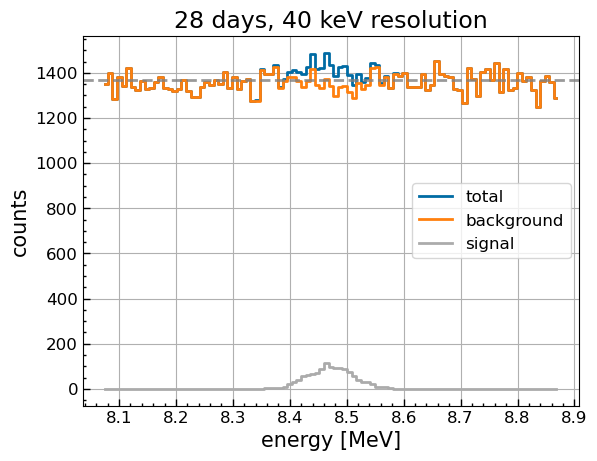

In [582]:
class Resolution:

    def __init__(self, sigma, B = hm_bg_rate/signal_rate, E1 = E1, dE = dE, N = Nsignal, Nbins = 100):
        self.sigma = sigma # resolution of delta-fxn peak
        self.B = B # background rate (relative to signal rate)
        self.dE = dE # width of energy ROI
        self.N_signal = N # number of signal events to sample in ROI
        self.N_background = int(N*B)
        self.E1 = E1 # MeV
        self.exposure_time = self.N_signal/signal_rate # sec
        self.Nbins = Nbins

    def generate_signal(self):
        self.signal = rng.normal(loc = self.E1, scale = self.sigma, size = self.N_signal)
    
    def generate_background(self):
        self.background = self.E1 + self.dE*(rng.uniform(size = self.N_background) - 0.5)


    def analyze(self):
        self.generate_signal()
        self.generate_background()

        # bin edges
        self.Ebins = np.linspace(self.E1 - self.dE/2, self.E1 + self.dE/2, self.Nbins)
        # bin centers
        self.Es = (self.Ebins[1:] + self.Ebins[:-1])/2 
        # bin widths
        self.dEs = np.diff(self.Ebins)

        self.signal_hist, _ = np.histogram(self.signal, bins = self.Ebins)
        self.background_hist, _ = np.histogram(self.background, bins = self.Ebins)
        self.hist = self.signal_hist + self.background_hist

        self.mean = self.hist.sum()
        self.expec = self.mean/(self.Nbins-1)

        self.chi2 = (((self.hist - self.expec)**2)/self.expec).sum()/self.Nbins


    def histogram(self, display_chi = True, **kwargs):
        plt.figure()
        plt.grid()

        plt.xlabel('energy [MeV]')
        plt.ylabel('counts')
        plt.title(f'{self.exposure_time/3600/24:.2g} days, {self.sigma*1e3:.2g} keV resolution')

        plt.step(self.Es, self.hist, where = 'mid', label = 'total')

        plt.step(self.Es, self.background_hist, where = 'mid', label = 'background')
        plt.step(self.Es, self.signal_hist, where = 'mid', label = 'signal')
        plt.legend()

        if display_chi:
            plt.text(self.Ebins[self.Nbins//4], self.hist[self.Nbins//4]/4, f'chi^2 = {self.chi2}')

        plt.axhline(self.expec, color = 'grey', linestyle = 'dashed', alpha = 0.8)



tr = Resolution(40e-3)
tr.analyze()

tr.histogram(display_chi = False)

print(tr.N_signal, tr.N_background)
print(tr.chi2)
plt.savefig('../figures/sim_4wk_hm1_example.pdf')

In [583]:
tr.N_signal+tr.N_background

135413

In [584]:
tr.N_background/dE

167748.75

In [585]:
0.28*fourweeks

677376.0000000001

In [586]:
Ntrials = 1000
best_resolution = 750
worst_resolution = 10
sigmas = E1*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis = np.zeros(sigmas.shape)

B = hm_bg_rate/signal_rate

for i, sigma in enumerate(tqdm.tqdm(sigmas)):
    res = Resolution(sigma, N = int(signal_rate*fourweeks), B = B)
    res.analyze()
    chis[i] = res.chi2


100%|██████████| 1000/1000 [00:07<00:00, 133.36it/s]


In [587]:
res.N_signal, res.N_background # highmass1

(1214, 134199)

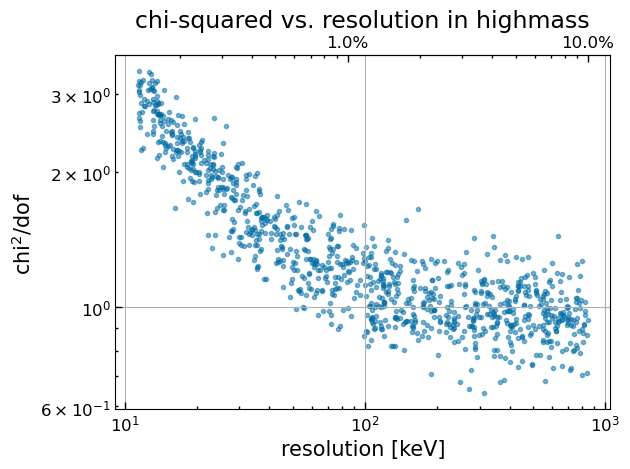

In [588]:
plt.figure()
plt.grid()
plt.loglog()
plt.title('chi-squared vs. resolution in highmass')
plt.xlabel('resolution [keV]')
plt.ylabel('chi$^2$/dof')
plt.scatter(sigmas*1e3, chis, marker = '.', alpha = 0.5)
ax = plt.gca()

E_to_P = lambda E: 100*E/(1e3*E1)
P_to_E = lambda P: 1e3*E1*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')
plt.tight_layout()
plt.savefig('../figures/sim_4wk_hm1_chi2.pdf')

In [589]:
E1/worst_resolution, E1/best_resolution

(0.8472270339079842, 0.011296360452106455)

In [590]:
100*0.3/E1

3.540963496126854

In [591]:
541632/fourweeks

0.2238888888888889

In [592]:
Ntrials = 1000
best_resolution = 400
worst_resolution = 5
sigmas_lm = E1_lm*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis_lm = np.zeros(sigmas_lm.shape)


for i, sigma in enumerate(tqdm.tqdm(sigmas_lm)):
    res_lm = Resolution(sigma, E1 = E1_lm, B = lm_bg_rate/signal_rate, dE = dE_lm)
    res_lm.analyze()
    chis_lm[i] = res_lm.chi2


100%|██████████| 1000/1000 [00:07<00:00, 136.16it/s]


In [593]:
res_lm.N_signal, res_lm.N_background

(1214, 134199)

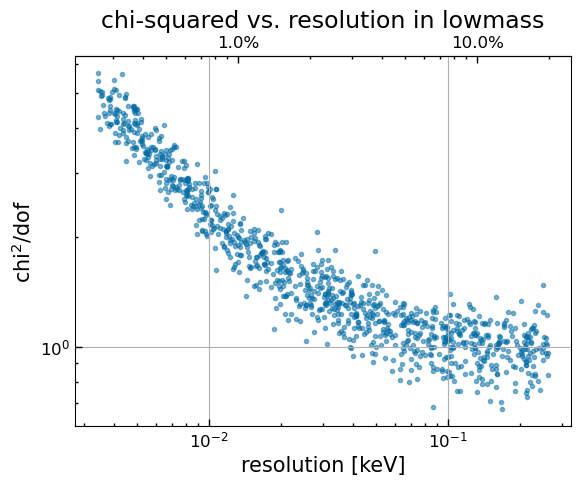

In [594]:
plt.figure()
plt.grid()
plt.loglog()
plt.title('chi-squared vs. resolution in lowmass')
plt.xlabel('resolution [keV]')
plt.ylabel('chi$^2$/dof')
plt.scatter(sigmas_lm*1e3, chis_lm, marker = '.', alpha = 0.5)
ax = plt.gca()

E_to_P = lambda E: 100*E/(1e3*E1_lm)
P_to_E = lambda P: 1e3*E1_lm*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')
plt.savefig('../figures/sim_4wk_lm_chi2.pdf')

In [595]:
dE_lm*1000

0.5

In [596]:
lm_bg_rate, hm_bg_rate

(0.0555, 0.0555)

In [597]:
signal_rate

0.00050206743

1214 134199


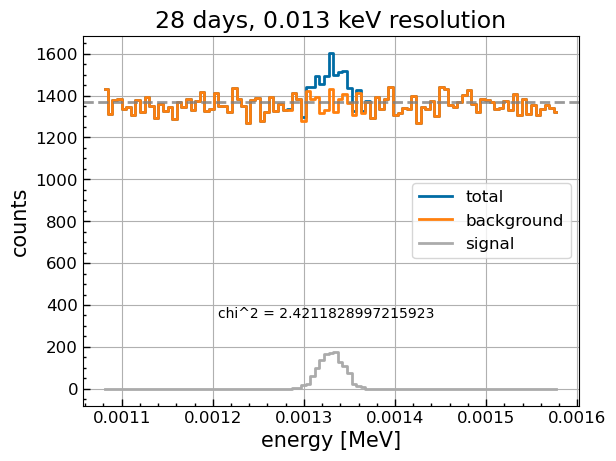

In [598]:
tr_lm = Resolution(E1_lm/100, E1 = E1_lm, B = lm_bg_rate/signal_rate, dE = dE_lm)
tr_lm.analyze()
tr_lm.histogram()
print(tr_lm.N_signal, tr_lm.N_background)

In [599]:
M = (29*931.5 - 21.895) # mass of Si-29 [MeV]
Ep = -M + np.sqrt(M**2 + 2*M*E1)
print(Ep**2 + 2*M*Ep - 2*M*E1)
(E1**2/2/M - Ep**2/2/M)


7.904600352048874e-08


4.171974475441608e-07

In [600]:
Ep

8.470941095358285

In [601]:
hm_bg_rate

0.0555

In [602]:
hm_bg_rate/dE

0.06937499999999999

Text(0, 0.5, 'probability $\\leq$3')

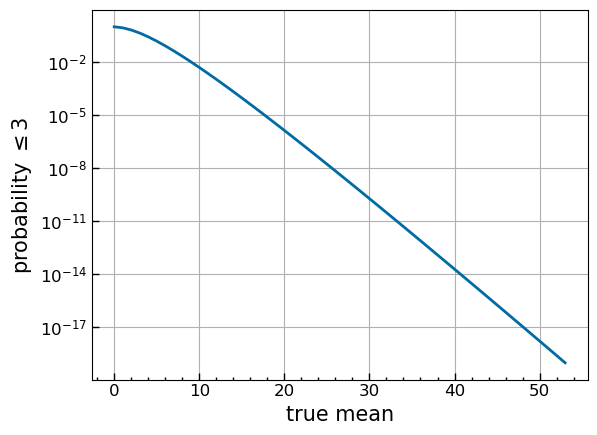

In [603]:
from scipy.stats import poisson

mus = np.arange(1, 55)
p = []

for mu in mus:

    p.append(poisson.cdf(3,mu))

plt.semilogy()
plt.plot(p)
plt.grid()
plt.xlabel('true mean')
plt.ylabel('probability $\\leq$3')

In [604]:
poisson.cdf(3, 30) # probability the actual mean is larger than 30 given meas = 3: 4.661032000779303e-10

4.661032000779303e-10

In [605]:
from scipy.stats import norm

norm.cdf(-6) # p-value for typical standard normal 6-sigma value: 9.865876450376944e-10

9.865876450376944e-10

In [606]:
40e-6/E1_lm

0.03008285750468013